In [66]:
!pip install kagglehub python-dotenv
!pip install pydot

In [67]:
import os
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [68]:
env_vars = dotenv_values("../../.env")
os.environ['KAGGLE_USERNAME'] = env_vars.get('KAGGLE_USERNAME', '')
os.environ['KAGGLE_KEY'] = env_vars.get('KAGGLE_KEY', '')
os.environ['KAGGLEHUB_CACHE'] = env_vars.get('KAGGLEHUB_CACHE', '')

print("Variables de entorno de Kaggle cargadas.")

Variables de entorno de Kaggle cargadas.


In [69]:
path = kagglehub.dataset_download("ahmedkhairy11/signclusive-mediapipe")

print("Path to dataset files:", path)

Path to dataset files: ../../model/data/raw/datasets/ahmedkhairy11/signclusive-mediapipe/versions/2


In [70]:
csv_path = '../data/raw/datasets/ahmedkhairy11/signclusive-mediapipe/versions/2/hand_keypoints.csv'
df = pd.read_csv(csv_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13450 entries, 0 to 13449
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   folder    13450 non-null  object 
 1   filename  13450 non-null  object 
 2   x0        13450 non-null  float64
 3   y0        13450 non-null  float64
 4   x1        13450 non-null  float64
 5   y1        13450 non-null  float64
 6   x2        13450 non-null  float64
 7   y2        13450 non-null  float64
 8   x3        13450 non-null  float64
 9   y3        13450 non-null  float64
 10  x4        13450 non-null  float64
 11  y4        13450 non-null  float64
 12  x5        13450 non-null  float64
 13  y5        13450 non-null  float64
 14  x6        13450 non-null  float64
 15  y6        13450 non-null  float64
 16  x7        13450 non-null  float64
 17  y7        13450 non-null  float64
 18  x8        13450 non-null  float64
 19  y8        13450 non-null  float64
 20  x9        13450 non-null  fl

In [71]:
# ETL
label_column ='folder'
feature_columns = [col for col in df.columns if col not in [label_column, 'filename']]
unique_labels = df[label_column].unique()

print(df[label_column].value_counts())

# missing_values = df.isnull().sum()
# print(missing_values[missing_values > 0])

# aumento de datos - convertir las fotos de la mano derecha en una foto de mano izquierda (TEST)
df_flipped = df.copy()

x_cols = [col for col in feature_columns if 'x' in col]
df_flipped[x_cols] = 1 - df_flipped[x_cols]

df_augmented = pd.concat([df, df_flipped], ignore_index=True)
missing_values = df_augmented.isnull().sum()
print(missing_values[missing_values > 0])


folder
A        500
M        500
Y        500
X        500
W        500
U        500
T        500
space    500
R        500
P        500
O        500
B        500
N        500
L        500
J        500
I        500
H        500
G        500
F        500
E        500
D        500
Z        500
S        499
K        497
V        494
C        493
Q        467
Name: count, dtype: int64
Series([], dtype: int64)


In [72]:
# EDA

X = df_augmented[feature_columns]
y = df_augmented[label_column]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns)

print(X_scaled_df.head())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nDimensiones de X_train: {X_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")
print(f"Número de clases únicas: {len(label_encoder.classes_)}")

joblib.dump(label_encoder, '../saved_models/label_encoder.pkl')
joblib.dump(scaler, os.path.join(save_dir, 'scaler.pkl'))


         x0        y0        x1        y1        x2        y2        x3  \
0 -2.362253 -2.281340 -2.063188 -2.291839 -1.636734 -2.309633 -1.547768   
1 -2.363597 -2.281366 -2.071570 -2.261639 -1.645237 -2.308648 -1.557576   
2 -2.330756 -2.004992 -2.016297 -2.045046 -1.604280 -2.039683 -1.522281   
3 -0.509934 -0.602133 -0.115320 -0.563685  0.211810 -0.588787  0.352672   
4 -0.508586 -0.592966 -0.119863 -0.549031  0.210407 -0.574552  0.355061   

         y3        x4        y4  ...       x16       y16       x17       y17  \
0 -2.331030 -1.442288 -2.364767  ... -2.315814 -1.358854 -2.270956 -2.124284   
1 -2.345874 -1.443519 -2.374196  ... -2.301456 -1.341956 -2.272413 -2.134958   
2 -2.077956 -1.418709 -2.132472  ... -2.283430 -1.111538 -2.258836 -1.843261   
3 -0.635875  0.446516 -0.752791  ... -0.436688  0.181937 -0.646019 -0.499187   
4 -0.631630  0.453280 -0.749722  ... -0.422350  0.182541 -0.639223 -0.498990   

        x18       y18       x19       y19       x20       y20  
0 -2

['../saved_models/scaler.pkl']

In [73]:
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [74]:
input_shape = X_train.shape[1]

model = keras.Sequential([

    keras.Input(shape=(input_shape,)),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(num_classes, activation='softmax')
])


In [75]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,915 (210.61 KB)

 Trainable params: 53,915 (210.61 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [77]:
EPOCHS = 50
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train_one_hot,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.3639 - loss: 2.0931 - val_accuracy: 0.9210 - val_loss: 0.2483
Epoch 2/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8549 - loss: 0.3926 - val_accuracy: 0.9605 - val_loss: 0.1331
Epoch 3/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9118 - loss: 0.2385 - val_accuracy: 0.9719 - val_loss: 0.0771
Epoch 4/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.9378 - loss: 0.1632 - val_accuracy: 0.9793 - val_loss: 0.0652
Epoch 5/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9492 - loss: 0.1448 - val_accuracy: 0.9944 - val_loss: 0.0291
Epoch 6/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.9655 - loss: 0.0957 - val_accuracy: 0.9972 - val_loss: 0.0213
Epoch 7/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.9696 - loss: 0.0880 - val_accuracy: 0.9988 - val_loss: 0.0114
Epoch 8/50
538/538 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9763 - loss: 0.0690 - 

In [78]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)

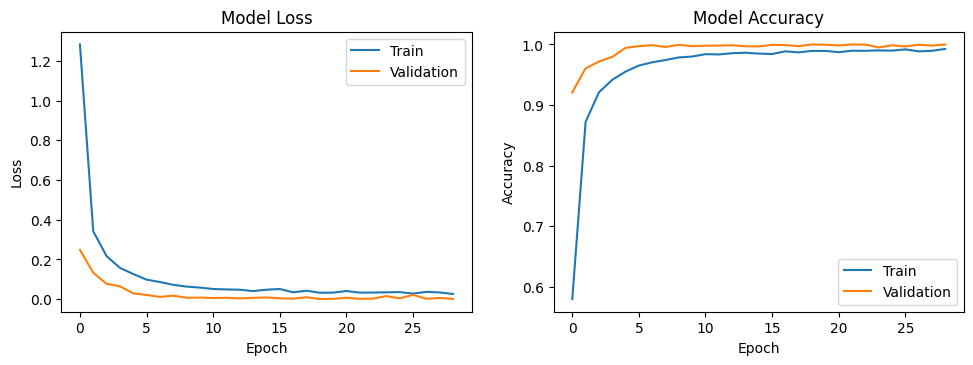

In [79]:
# Train

plt.figure(figsize=(18, 8))

# Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Best Epoch'], loc='upper right')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation', 'Best Epoch'], loc='lower right')

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


<Figure size 1500x1500 with 0 Axes>

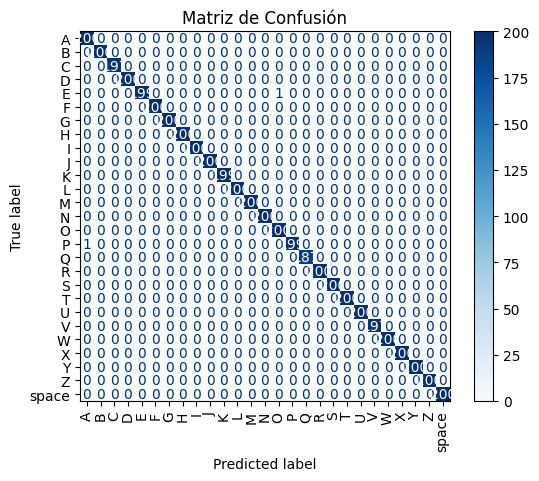

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probabilities = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probabilities, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

display_labels = label_encoder.classes_

plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matriz de Confusión')
plt.show()

# print("\nMatriz de Confusión (numérica):\n", cm)

In [81]:
save_dir='../saved_models'

model_save_path = os.path.join(save_dir, 'signclusive-mediapipe-model.keras')
model.save(model_save_path)

print(f"modelo guardado en: {model_save_path}")


modelo guardado en: ../saved_models/signclusive-mediapipe-model.keras
